In [166]:
import math, matplotlib.pyplot as plt, torch

In [167]:
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

# Create data

In [168]:
n_clusters = 4
n_samples = 250

In [169]:
true_centroids = torch.rand(n_clusters, 2)*70-35
true_centroids

tensor([[ 10.214,  -8.897],
        [-17.047,  -8.173],
        [ 12.280, -19.926],
        [  0.429, -32.859]])

In [170]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [171]:
def get_samples(centroid):
    return MultivariateNormal(centroid, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [172]:
slices = [get_samples(c) for c in true_centroids]
len(slices)

4

In [173]:
data = torch.cat(slices)
data.shape

torch.Size([1000, 2])

In [174]:
def plot_data(centroids, data, labels=None, n_samples=250, ax=None):
    if ax is None: 
        fig,ax = plt.subplots()
    if labels is not None:
        ax.scatter(data[:,0], data[:,1], c=labels, s=1)
        for centroid in centroids:
            ax.plot(*centroid, marker='x', markersize=10, color='k', mew=5)
            ax.plot(*centroid, marker='x', markersize=5, color='m', mew=2)
    else:
        for i,centroid in enumerate(centroids):
            c = data[i*n_samples:(i+1)*n_samples]
            ax.scatter(c[:,0], c[:,1], s=1)
            ax.plot(*centroid, marker='x', markersize=10, color='k', mew=5)
            ax.plot(*centroid, marker='x', markersize=5, color='m', mew=2)

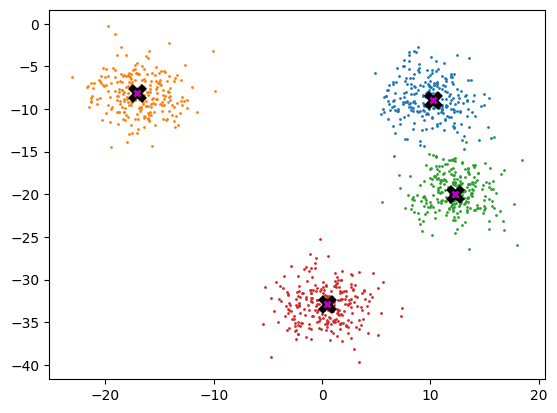

In [175]:
plot_data(true_centroids, data)

# k-Means clustering algorithm

The number of clusters (```k```) must be specified. 

The algorithm is as follows:

1. ```k``` initial centroids are randomly selected from data points. 
2. Each data point is assigned to the cluster whose centroid is closest to it (distance metric of choice used to compute distances--I'll use **L2 norm** here). 
3. Centroids of clusters are updated by taking mean of all data points assigned to that cluster. 

Steps 2 and 3 repeated until convergence of cluster assignments. 

**Note:** k-means is sensitive to the intial centroids; final clustering can vary based on initialization of centroids. Thus, it's usually run multiple times with different initializations. 

In [176]:
idx = torch.randperm(len(data))[:4]

This randomly permutes number between 0 and len(data). I indexed the first 6 -- the coordinates at these indices will be our randomly initialized centroids.

In [177]:
centroids = data[idx, :]
centroids

tensor([[  9.935, -20.925],
        [-17.180,  -5.836],
        [ 12.073, -11.952],
        [  4.287, -36.275]])

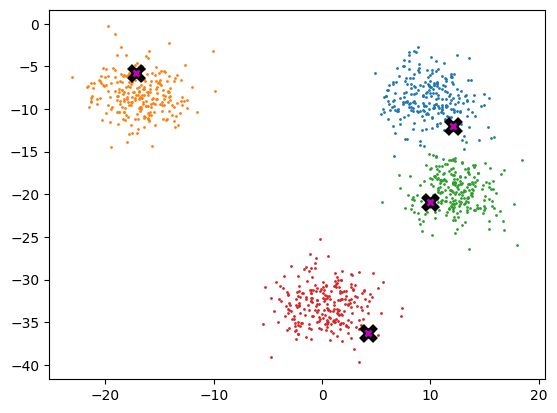

In [178]:
plot_data(centroids, data)

Calculate distances between centroids and each data point.

In [179]:
X = data.clone()

In [180]:
X.shape, centroids.shape

(torch.Size([1000, 2]), torch.Size([4, 2]))

In [181]:
X[None].shape, centroids[:,None].shape

(torch.Size([1, 1000, 2]), torch.Size([4, 1, 2]))

In [182]:
%time ((X[None] - centroids[:,None])**2).sum(2).sqrt()

CPU times: user 0 ns, sys: 626 µs, total: 626 µs
Wall time: 369 µs


tensor([[15.195, 12.798, 13.739,  ..., 13.805, 15.948, 13.602],
        [29.069, 29.129, 27.533,  ..., 34.304, 31.200, 37.480],
        [ 6.098,  3.688,  5.073,  ..., 22.861, 24.380, 22.824],
        [31.354, 29.007, 29.703,  ...,  3.195,  6.496,  3.583]])

In [183]:
diff = X[None] - centroids[:,None]

In [184]:
%time torch.einsum("ijk,ijk->ij", diff, diff).sqrt()

CPU times: user 268 µs, sys: 37 µs, total: 305 µs
Wall time: 314 µs


tensor([[15.195, 12.798, 13.739,  ..., 13.805, 15.948, 13.602],
        [29.069, 29.129, 27.533,  ..., 34.304, 31.200, 37.480],
        [ 6.098,  3.688,  5.073,  ..., 22.861, 24.380, 22.824],
        [31.354, 29.007, 29.703,  ...,  3.195,  6.496,  3.583]])

In [185]:
def dist(diff):
    return torch.einsum("ijk,ijk->ij", diff, diff).sqrt()

In [186]:
distance = dist(diff)

In [187]:
distance.shape

torch.Size([4, 1000])

Cluster assignments based on closest centroid to each point:

In [188]:
labels = distance.argmin(0)

Update centroids as the average of all data points assigned to its cluster:

In [189]:
X[labels == 2].shape

torch.Size([274, 2])

In [190]:
def update_centroids(k, X, labels, centroids):
    for i in range(k):
        mask = (labels == i)
        if mask.any():
            new_cent = X[mask].mean(0)
            centroids[i] = new_cent
    return centroids

In [191]:
centroids = update_centroids(4, X, labels, centroids)
centroids, labels.shape

(tensor([[ 12.051, -20.090],
         [-16.873,  -8.266],
         [ 10.248,  -9.475],
         [  0.294, -32.982]]),
 torch.Size([1000]))

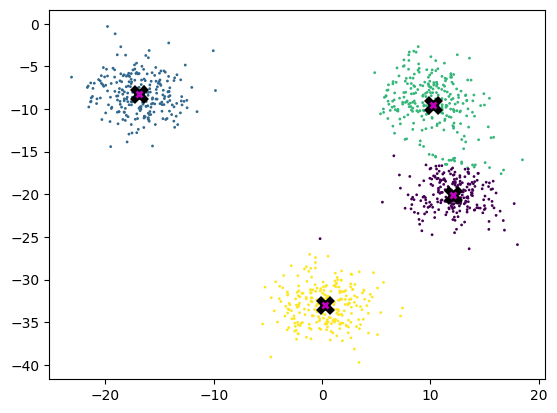

In [192]:
plot_data(centroids, X, labels=labels)

# Putting all the pieces together

In [193]:
def kmeans(X, centroids, k, n_iter=5):
    for i in range(n_iter):
        diff = X[None] - centroids[:,None]
        distance = dist(diff)
        labels = distance.argmin(0)
        centroids = update_centroids(k, X, labels, centroids)
    return centroids, labels

In [194]:
idx = torch.randperm(len(X))[:4]
centroids = X[idx, :]

In [195]:
centroids, labels = kmeans(X, centroids, k=4, n_iter=10)

In [196]:
%time centroids, labels = kmeans(X, centroids, k=4, n_iter=10)

CPU times: user 16.4 ms, sys: 896 µs, total: 17.3 ms
Wall time: 8.38 ms


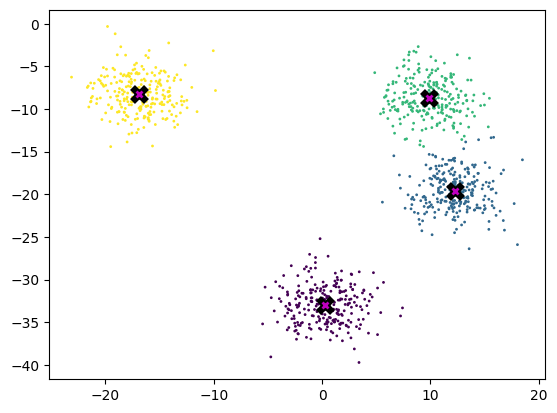

In [197]:
plot_data(centroids, X, labels)

In [198]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from functools import partial

In [199]:
def do_one(d, X, centroids):
    if d: 
        centroids,labels = kmeans(X,centroids,4)
    else: 
        labels = torch.zeros(len(X), dtype=torch.long)
    ax.clear()
    plot_data(centroids, X, labels, ax=ax)

In [200]:
idx = torch.randperm(len(X))[:4]
centroids = X[idx, :]
fig,ax = plt.subplots()
ani = FuncAnimation(fig, partial(do_one, X=X, centroids=centroids), frames=5, interval=500, repeat=False)
plt.close(fig)
HTML(ani.to_jshtml())

# GPU accelerated

In [201]:
def kmeans_gpu(X, k, n_iter=5):
    idx = torch.randperm(len(X))[:4]
    centroids = X[idx, :]
    for i in range(n_iter):
        diff = X[None] - centroids[:,None]
        distance = dist(diff)
        labels = distance.argmin(0)
        centroids = update_centroids(k, X, labels, centroids)
    return centroids, labels

In [202]:
X = data.cuda()

In [203]:
# centroids, labels = [t.cpu() for t in kmeans_gpu(X, k=4)]

In [204]:
%time centroids, labels = [t.cpu() for t in kmeans_gpu(X, k=4)]

CPU times: user 4.1 ms, sys: 893 µs, total: 4.99 ms
Wall time: 4.69 ms


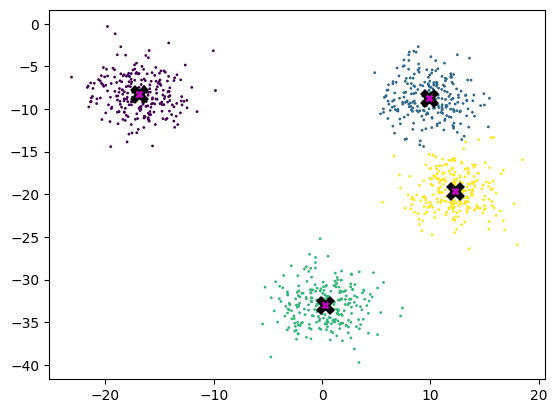

In [205]:
plot_data(centroids, X.cpu(), labels)

The cluster assignments vary greatly based on the initial centroid positions with the k-means algorithm. So, we might want to multiple trials of the algorithm:

# Enabling multiple trials

In [208]:
n_trials = 3
l_centroids = []
l_labels = []
for t in range(n_trials):
    centroids,labels = kmeans_gpu(X, k=4)
    l_centroids.append(centroids.cpu())
    l_labels.append(labels.cpu())

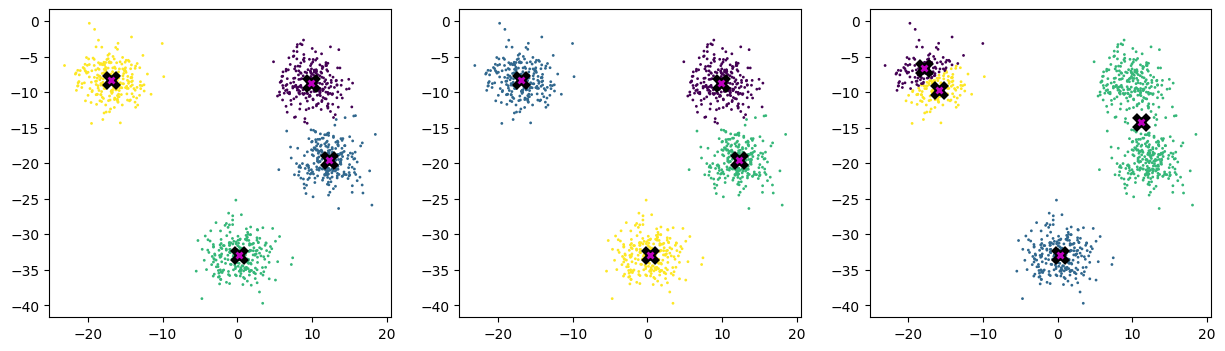

In [217]:
n = len(l_centroids)
fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))
for i,(cent,ax) in enumerate(zip(l_centroids,axes)):
    plot_data(cent, data, l_labels[i], ax=ax)